In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, VGG16, MobileNet
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.metrics import AUC
import matplotlib.pyplot as plt
import pandas as pd
import os
import zipfile
import seaborn as sns

In [2]:
# Impostazioni
RANDOM_STATE = 17
N_CLASSES = 20
IMG_SIZE = (224, 224, 3)
BATCH_SIZE = 128
EPOCHS = 20

STEPS_PER_EPOCH = 9232 // BATCH_SIZE
VALIDATION_STEPS = 1154 // BATCH_SIZE
TEST_STEPS = 1154 // BATCH_SIZE

In [3]:
# Impostiamo i semi per la riproducibilità
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
keras.utils.set_random_seed(RANDOM_STATE)

In [4]:
# Montiamo Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ROOT_DIR = 'drive/MyDrive/AdvanceMachineLearning/ProgettoFinale/'
IMAGE_ZIP = ROOT_DIR + "project/dataset/images.zip"
IMG_EXTRACT_DIR = "content/dataset/"
ANNOTATIONS_DATASET = ROOT_DIR + 'project/dataset/annotations/'

# Percorsi immagini
IMG_DIR = IMG_EXTRACT_DIR + 'images/'
TRAIN_IMAGE_DIR = IMG_DIR + 'train/'
VALIDATION_IMAGE_DIR = IMG_DIR + 'validation/'
TEST_IMAGE_DIR = IMG_DIR + 'test/'

Mounted at /content/drive


In [5]:
# Estrai il file ZIP se necessario
os.makedirs(IMG_EXTRACT_DIR, exist_ok=True)
with zipfile.ZipFile(IMAGE_ZIP, 'r') as zip_ref:
    zip_ref.extractall(IMG_EXTRACT_DIR)

In [6]:
# Caricamento etichette
CLASSES = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
           "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
           "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
classes_map = {c: i for i, c in enumerate(CLASSES)}

In [12]:
# Funzioni di preprocessing
def load_csv(csv_path, image_dir):
    df = pd.read_csv(csv_path)
    file_paths = df['file'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg")).tolist()
    classes_ids = df['classes_id'].apply(lambda x: eval(x))
    return file_paths, classes_ids

def vector_encoding(labels, num_classes):
    class_vector = np.zeros(num_classes)
    for label in labels:
        class_vector[label - 1] = 1
    return class_vector

def preprocess_image(image_path, preprocess_fn, resize=IMG_SIZE):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, resize[:2])
    return preprocess_fn(image)

def create_tf_dataset(csv_path, image_dir, preprocess_fn=lambda x: x, batch_size=BATCH_SIZE, resize=IMG_SIZE, num_classes=N_CLASSES):
    image_paths, label_ids = load_csv(csv_path, image_dir)
    label_ids = [vector_encoding(labels, num_classes) for labels in label_ids]

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_ids))

    def load_and_preprocess(image_path, labels):
        image = preprocess_image(image_path, preprocess_fn, resize)
        return image, labels

    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)

# Funzioni di visualizzazione
def show_sample_images(dataset, num_images=5):
    plt.figure(figsize=(10, 10))
    for i, (images, labels) in enumerate(dataset.take(1)):
        for j in range(num_images):
            plt.subplot(1, num_images, j + 1)
            plt.imshow(images[j].numpy().astype("uint8"))
            label_indices = np.where(labels[j].numpy() > 0.5)[0]
            label_names = [CLASSES[i] for i in label_indices]
            plt.title("\n".join(label_names))
            plt.axis("off")
    plt.show()

In [8]:
# Caricamento dataset
train_dataset = create_tf_dataset(ANNOTATIONS_DATASET + "train.csv", TRAIN_IMAGE_DIR)
validation_dataset = create_tf_dataset(ANNOTATIONS_DATASET + "validation.csv", VALIDATION_IMAGE_DIR)
test_dataset = create_tf_dataset(ANNOTATIONS_DATASET + "test.csv", TEST_IMAGE_DIR)

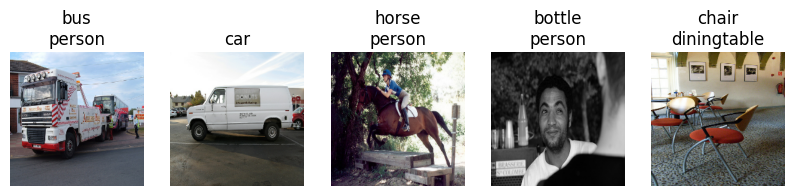

In [9]:
# Mostra alcune immagini di esempio
show_sample_images(train_dataset)

In [8]:
# Mean Average Precision (mAP) usando AUC con curva Precision-Recall
map_metric = AUC(
    curve='PR',  # Precision-Recall curve
    multi_label=True,
    name='mAP'
)

# Top-3 Accuracy
top_3_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(
    k=3,
    name='top_3_accuracy'
)

adam = Adam(learning_rate=0.001)

def build_model(model):
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy', map_metric, top_3_accuracy])
    model.summary()
    return model

In [9]:
# Costruzione modelli
def train_model(model, train_dataset, validation_dataset, epochs=EPOCHS):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS, callbacks=[early_stopping])
    return history

# Funzione di plot della cronologia
def plot_history(history) -> None:
    metrics = list(history.history.keys())
    n_metrics = len([m for m in metrics if not m.startswith('val_')])
    n_cols = 2
    n_rows = (n_metrics + 1) // 2  # Arrotonda per eccesso
    fig, axis = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    fig.tight_layout(pad=3.0)

    if n_rows > 1:
        axis = axis.flatten()

    plot_index = 0
    base_metrics = [m for m in metrics if not m.startswith('val_')]

    for metric in base_metrics:
        val_metric = f'val_{metric}'
        if metric not in history.history:
            continue

        train_data = history.history[metric]
        val_data = history.history[val_metric] if val_metric in history.history else None
        if n_rows > 1:
            current_axis = axis[plot_index]
        else:
            current_axis = axis[plot_index] if n_cols > 1 else axis

        current_axis.set_title(f'{metric.capitalize()}')
        current_axis.set_xlabel('Epochs')
        current_axis.set_ylabel(metric.capitalize())

        current_axis.plot(train_data, label=f'Training {metric.capitalize()}')
        if val_data is not None:
            current_axis.plot(val_data, label=f'Validation {metric.capitalize()}')

        current_axis.legend()
        plot_index += 1

    while plot_index < len(axis):
        fig.delaxes(axis[plot_index])
        plot_index += 1

    plt.show()

In [10]:
def show_predictions(model, dataset, num_images=5, threshold=0.5):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        for i in range(num_images):
            predicted_indices = np.where(predictions[i] > threshold)[0]
            predicted_labels = [CLASSES[idx] for idx in predicted_indices]

            true_indices = np.where(labels[i].numpy() > 0.5)[0]
            true_labels = [CLASSES[idx] for idx in true_indices]

            plt.subplot(1, num_images, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))

            title = f"Pred: {', '.join(predicted_labels)}\nTrue: {', '.join(true_labels)}"
            plt.title(title)

            plt.axis("off")
    plt.show()

# Valutazione
def evaluate_model(model, test_dataset, name):
    loss, acc, top_3_acc, map_m = model.evaluate(test_dataset, steps = TEST_STEPS)
    print(f"{name} Test Accuracy: {acc:.4f}, Top-3 Accuracy: {top_3_acc:.4f}, Mean Average Precision: {map_m:.4f} ")
    show_predictions(model, test_dataset)
    return {'name': name, 'acc': acc, 'top_3_acc': top_3_acc, 'map_metric': map_m}

# ResNet50

In [13]:
# Caricamento dataset
resnet_train_dataset = create_tf_dataset(ANNOTATIONS_DATASET + "train.csv", TRAIN_IMAGE_DIR, resnet_preprocess_input)
resnet_validation_dataset = create_tf_dataset(ANNOTATIONS_DATASET + "validation.csv", VALIDATION_IMAGE_DIR, resnet_preprocess_input)
resnet_test_dataset = create_tf_dataset(ANNOTATIONS_DATASET + "test.csv", TEST_IMAGE_DIR, resnet_preprocess_input)

## Base ResNet50

In [14]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], IMG_SIZE[2]))
resnet_base.trainable = False
model_base_resnet = models.Sequential([
    resnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(N_CLASSES, activation='sigmoid')
])
model_base_resnet = build_model(model_base_resnet)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │          40,980 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,628,692 (90.14 MB)

 Trainable params: 40,980 (160.08 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:
history_base_resnet = train_model(model_base_resnet, resnet_train_dataset, resnet_validation_dataset)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 69s 648ms/step - accuracy: 0.3060 - loss: 0.2677 - mAP: 0.2322 - top_3_accuracy: 0.5172 - val_accuracy: 0.6823 - val_loss: 0.1035 - val_mAP: 0.7257 - val_top_3_accuracy: 0.8984
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 44s 551ms/step - accuracy: 0.6894 - loss: 0.0959 - mAP: 0.7531 - top_3_accuracy: 0.9132 - val_accuracy: 0.7049 - val_loss: 0.0871 - val_mAP: 0.7889 - val_top_3_accuracy: 0.9115
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 544ms/step - accuracy: 0.7166 - loss: 0.0810 - mAP: 0.8168 - top_3_accuracy: 0.9310 - val_accuracy: 0.7196 - val_loss: 0.0812 - val_mAP: 0.8096 - val_top_3_accuracy: 0.9149
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 558ms/step - accuracy: 0.7335 - loss: 0.0733 - mAP: 0.8430 - top_3_accuracy: 0.9415 - val_accuracy: 0.7214 - val_loss: 0.0784 - val_mAP: 0.8187 - val_top_3_accuracy: 0.9236
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 570ms/step - accuracy: 0.7460 - loss: 0.0682 - mAP: 0.8627 - top_3_accuracy: 0.9431 - val_accuracy

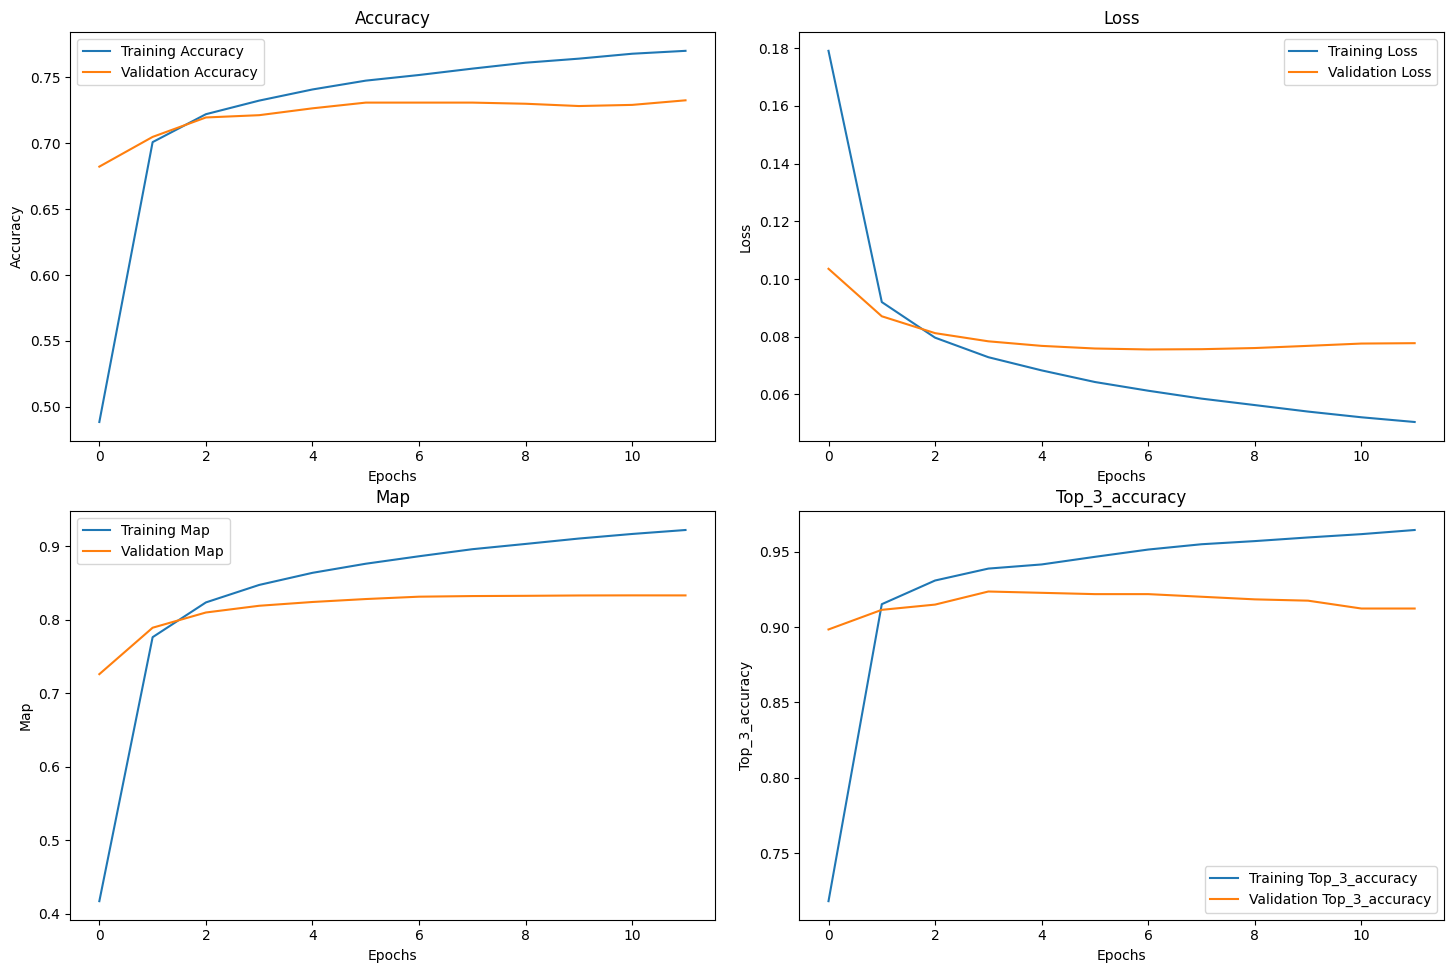

In [18]:
plot_history(history_base_resnet)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 417ms/step - accuracy: 0.7266 - loss: 0.0784 - mAP: 0.6881 - top_3_accuracy: 0.9074
ResNet50 Test Accuracy: 0.7352, Top-3 Accuracy: 0.8337, Mean Average Precision: 0.9123 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


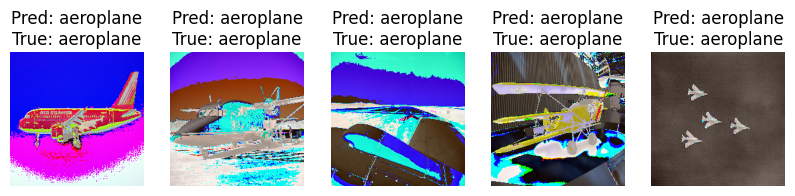

In [19]:
score_base_resnet = evaluate_model(model_base_resnet, resnet_test_dataset, "ResNet50")

In [20]:
model_base_resnet.save('model_base_resnet.keras')

## Fine Tuning ResNet50

In [14]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], IMG_SIZE[2]))

set_trainable = False
for layer in resnet_base.layers:
    if "conv5_block" in layer.name:
        set_trainable = True
    layer.trainable = set_trainable

model_ft_resnet = models.Sequential([
    resnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(516, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(N_CLASSES, activation='sigmoid')
])
model_ft_resnet = build_model(model_ft_resnet)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 516)                 │       1,057,284 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 516)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │          10,340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,655,336 (94.05 MB)

 Trainable params: 16,043,624 (61.20 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

In [15]:
history_ft_resnet = train_model(model_ft_resnet, resnet_train_dataset, resnet_validation_dataset)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 83s 644ms/step - accuracy: 0.4822 - loss: 0.2003 - mAP: 0.4386 - top_3_accuracy: 0.6880 - val_accuracy: 0.4080 - val_loss: 0.5479 - val_mAP: 0.2882 - val_top_3_accuracy: 0.5781
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 78s 951ms/step - accuracy: 0.6907 - loss: 0.0856 - mAP: 0.7996 - top_3_accuracy: 0.9097 - val_accuracy: 0.6146 - val_loss: 0.1298 - val_mAP: 0.7478 - val_top_3_accuracy: 0.8481
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 589ms/step - accuracy: 0.7567 - loss: 0.0586 - mAP: 0.8940 - top_3_accuracy: 0.9455 - val_accuracy: 0.6884 - val_loss: 0.0949 - val_mAP: 0.8002 - val_top_3_accuracy: 0.8993
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 556ms/step - accuracy: 0.7690 - loss: 0.0430 - mAP: 0.9395 - top_3_accuracy: 0.9655 - val_accuracy: 0.6701 - val_loss: 0.1378 - val_mAP: 0.7643 - val_top_3_accuracy: 0.8785
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 543ms/step - accuracy: 0.7852 - loss: 0.0338 - mAP: 0.9585 - top_3_accuracy: 0.9753 - val_accuracy

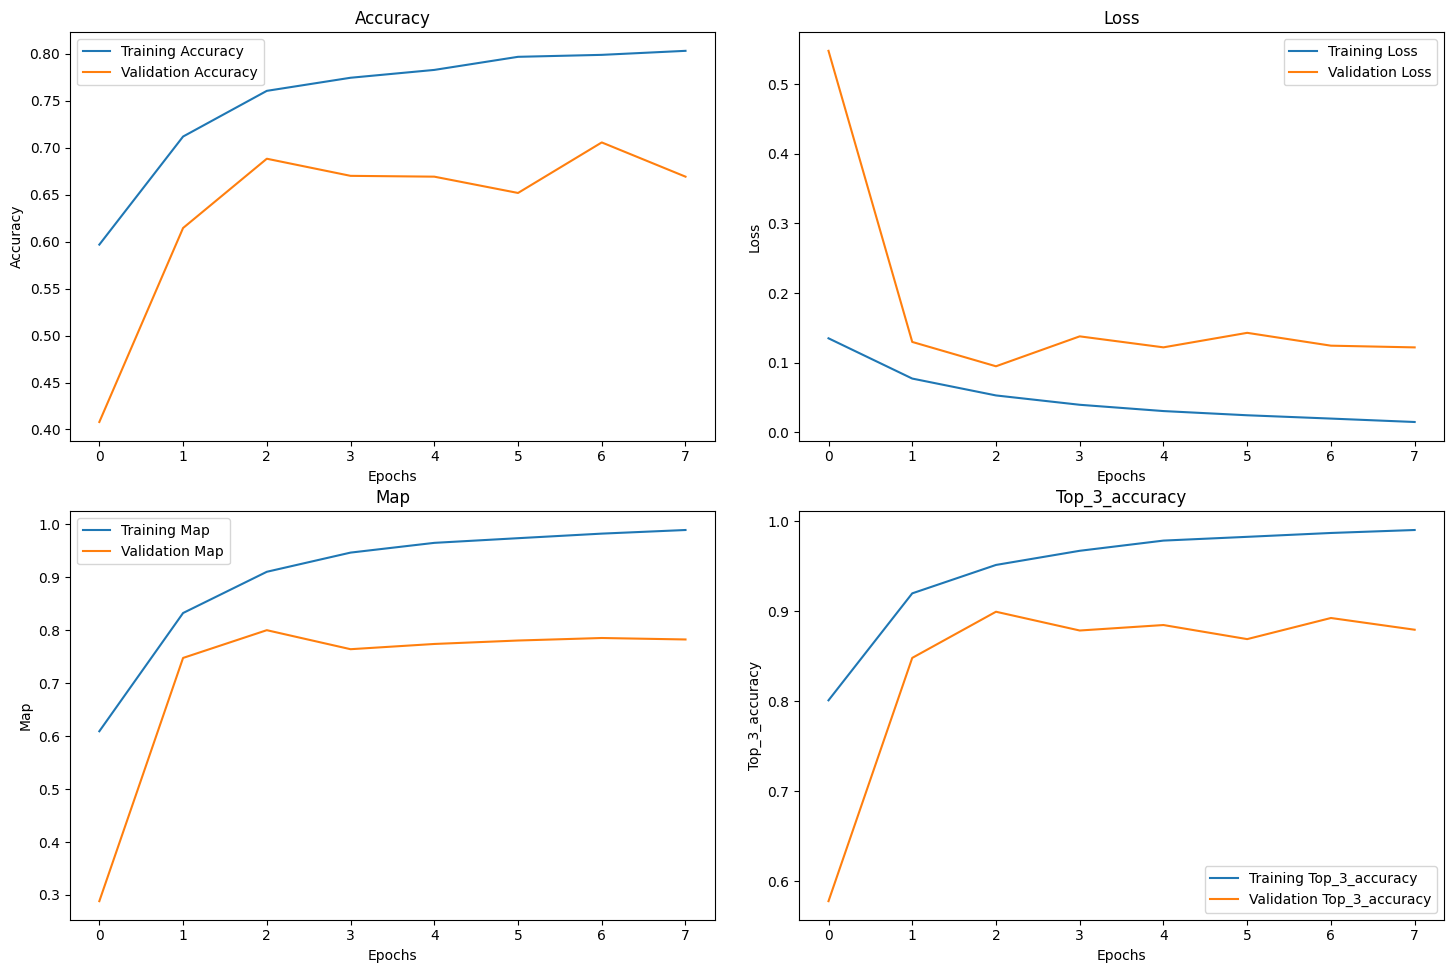

In [16]:
plot_history(history_ft_resnet)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 453ms/step - accuracy: 0.7062 - loss: 0.1038 - mAP: 0.6630 - top_3_accuracy: 0.8671
ResNet50 with Fine Tuning Test Accuracy: 0.6901, Top-3 Accuracy: 0.8024, Mean Average Precision: 0.8819 
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step


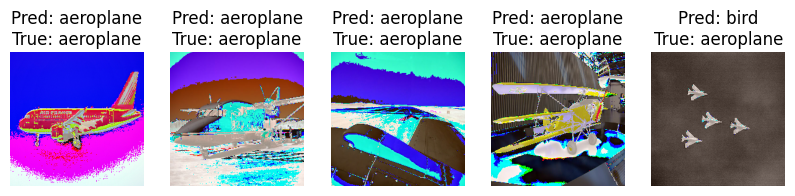

In [17]:
score_ft_resnet = evaluate_model(model_ft_resnet, resnet_test_dataset, "ResNet50 with Fine Tuning")

In [18]:
model_ft_resnet.save('model_ft_resnet.keras')

# VGG16

In [13]:
vgg_train_dataset = create_tf_dataset(ANNOTATIONS_DATASET + "train.csv", TRAIN_IMAGE_DIR, vgg_preprocess_input)
vgg_validation_dataset = create_tf_dataset(ANNOTATIONS_DATASET + "validation.csv", VALIDATION_IMAGE_DIR, vgg_preprocess_input)
vgg_test_dataset = create_tf_dataset(ANNOTATIONS_DATASET + "test.csv", TEST_IMAGE_DIR, vgg_preprocess_input)

## Base VGG16

In [15]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], IMG_SIZE[2]))
vgg_base.trainable = False
model_base_vgg = models.Sequential([
    vgg_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(516, activation='relu'),
    layers.Dense(N_CLASSES, activation='sigmoid')
])
model_base_vgg = build_model(model_base_vgg)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 516)                 │         528,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │          10,340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,779,240 (60.19 MB)

 Trainable params: 1,064,552 (4.06 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
history_base_vgg = train_model(model_base_vgg, vgg_train_dataset, vgg_validation_dataset)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 86s 718ms/step - accuracy: 0.4538 - loss: 0.3044 - mAP: 0.4011 - top_3_accuracy: 0.6618 - val_accuracy: 0.6875 - val_loss: 0.0875 - val_mAP: 0.7938 - val_top_3_accuracy: 0.8915
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 51s 606ms/step - accuracy: 0.6922 - loss: 0.0810 - mAP: 0.8119 - top_3_accuracy: 0.9171 - val_accuracy: 0.6962 - val_loss: 0.0824 - val_mAP: 0.8111 - val_top_3_accuracy: 0.9002
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 45s 625ms/step - accuracy: 0.7356 - loss: 0.0630 - mAP: 0.8773 - top_3_accuracy: 0.9436 - val_accuracy: 0.6962 - val_loss: 0.0818 - val_mAP: 0.8152 - val_top_3_accuracy: 0.9002
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7602 - loss: 0.0497 - mAP: 0.9203 - top_3_accuracy: 0.9626 - val_accuracy: 0.7092 - val_loss: 0.0848 - val_mAP: 0.8115 - val_top_3_accuracy: 0.9071
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 45s 620ms/step - accuracy: 0.7761 - loss: 0.0383 - mAP: 0.9514 - top_3_accuracy: 0.9748 - val_accuracy: 0

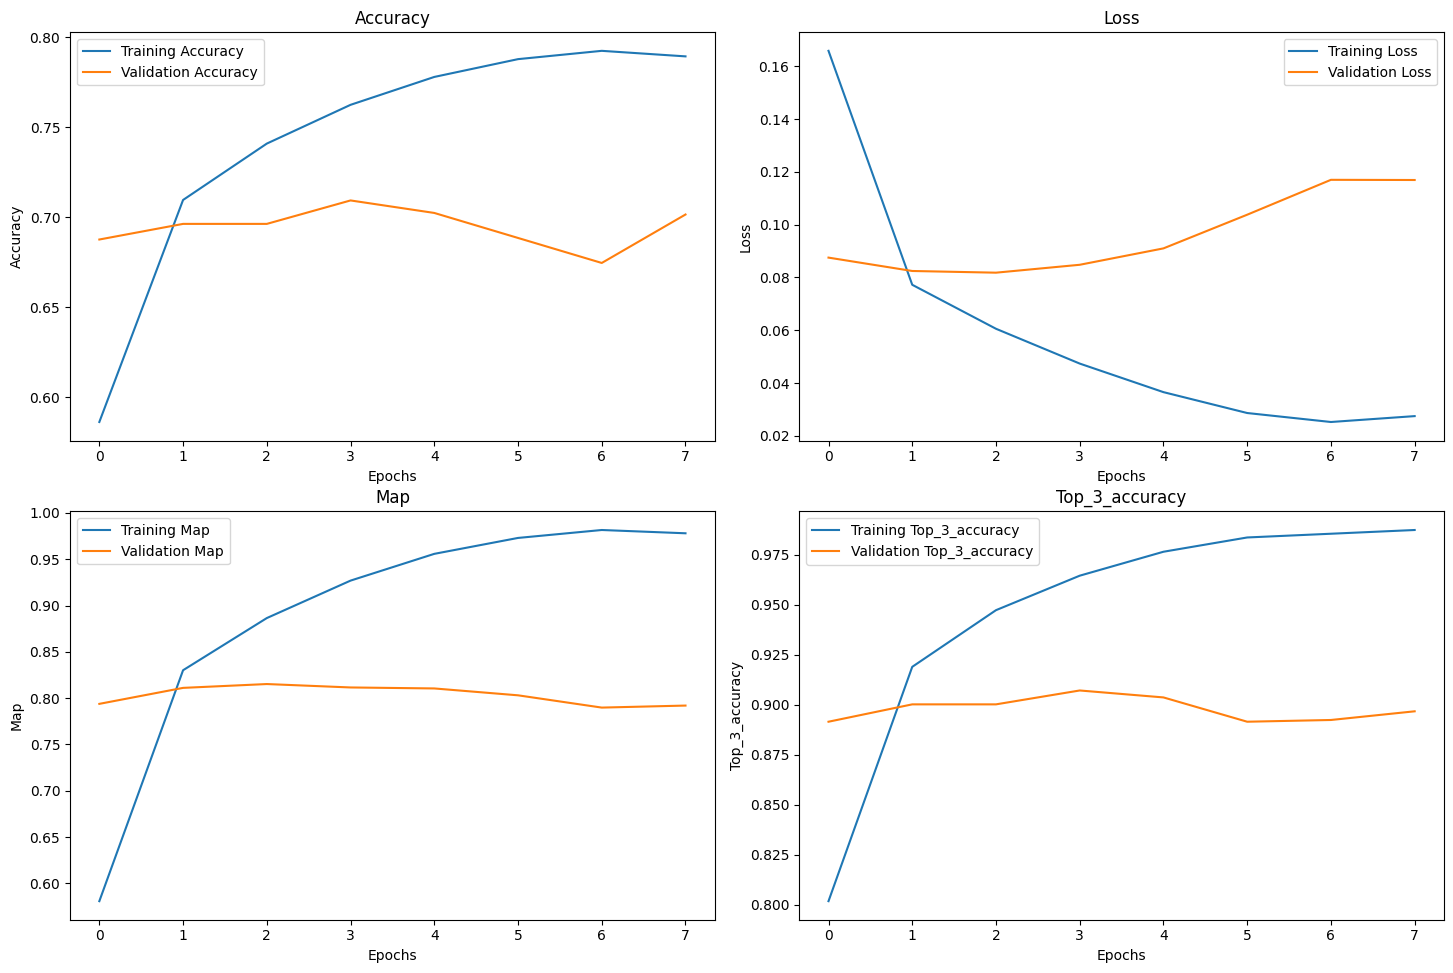

In [17]:
plot_history(history_base_vgg)

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 726ms/step - accuracy: 0.7014 - loss: 0.0863 - mAP: 0.6681 - top_3_accuracy: 0.9028
VGG16 Test Accuracy: 0.7057, Top-3 Accuracy: 0.8255, Mean Average Precision: 0.9010 
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step


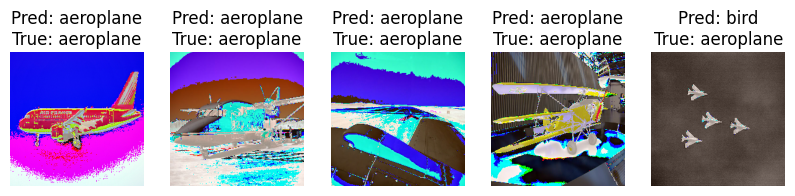

In [18]:
score_base_vgg = evaluate_model(model_base_vgg, vgg_test_dataset, "VGG16")

In [18]:
model_base_vgg.save('model_base_vgg.keras')

## VGG Fine Tuning

In [14]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], IMG_SIZE[2]))
vgg_base.trainable = False
model_ft_vgg = models.Sequential([
    vgg_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(516, activation='relu'),
    layers.Dense(N_CLASSES, activation='sigmoid')
])
model_ft_vgg = build_model(model_ft_vgg)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 516)                 │         528,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │          10,340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,779,240 (60.19 MB)

 Trainable params: 1,064,552 (4.06 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [15]:
history_ft_vgg = train_model(model_ft_vgg, vgg_train_dataset, vgg_validation_dataset)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 91s 744ms/step - accuracy: 0.4534 - loss: 0.3044 - mAP: 0.4012 - top_3_accuracy: 0.6616 - val_accuracy: 0.6814 - val_loss: 0.0875 - val_mAP: 0.7941 - val_top_3_accuracy: 0.8889
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.6959 - loss: 0.0812 - mAP: 0.8116 - top_3_accuracy: 0.9177 - val_accuracy: 0.7014 - val_loss: 0.0817 - val_mAP: 0.8144 - val_top_3_accuracy: 0.8993
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 46s 638ms/step - accuracy: 0.7395 - loss: 0.0630 - mAP: 0.8768 - top_3_accuracy: 0.9447 - val_accuracy: 0.7005 - val_loss: 0.0819 - val_mAP: 0.8154 - val_top_3_accuracy: 0.8950
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7607 - loss: 0.0503 - mAP: 0.9169 - top_3_accuracy: 0.9600 - val_accuracy: 0.7040 - val_loss: 0.0854 - val_mAP: 0.8129 - val_top_3_accuracy: 0.9010
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7748 - loss: 0.0396 - mAP: 0.9482 - top_3_accuracy: 0.9702 - val_accuracy: 0.7049 

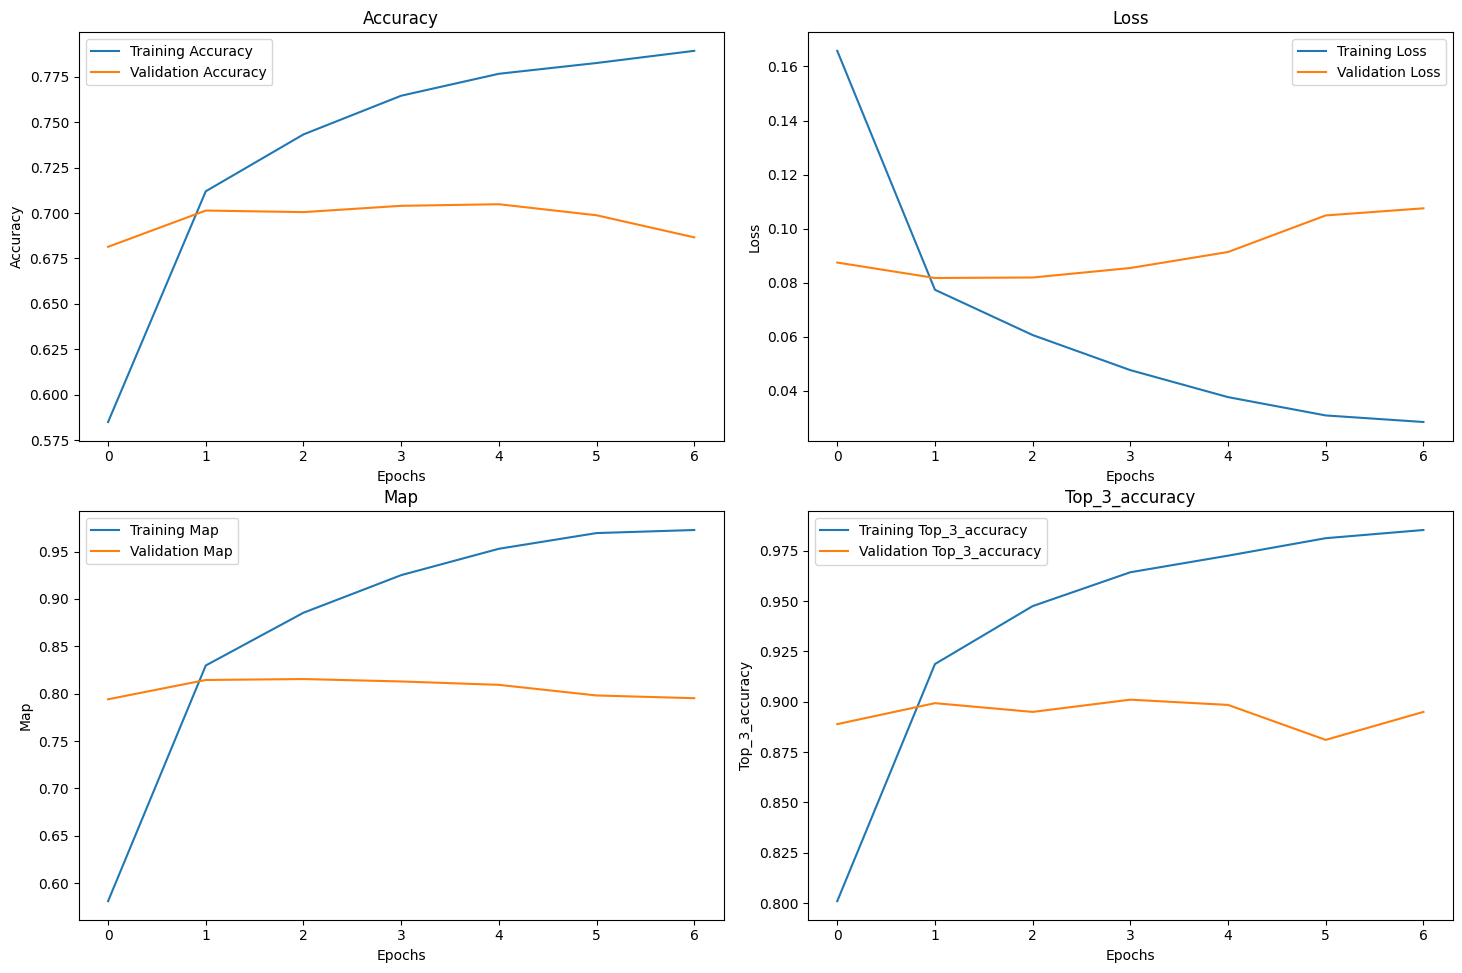

In [16]:
plot_history(history_ft_vgg)

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 547ms/step - accuracy: 0.6965 - loss: 0.0867 - mAP: 0.6634 - top_3_accuracy: 0.9037
VGG16 with Fine Tuning Test Accuracy: 0.6997, Top-3 Accuracy: 0.8203, Mean Average Precision: 0.9045 
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step


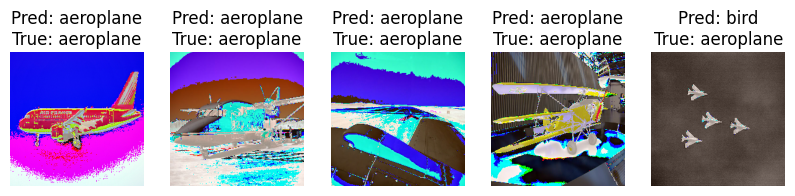

In [17]:
score_ft_vgg = evaluate_model(model_ft_vgg, vgg_test_dataset, "VGG16 with Fine Tuning")

In [18]:
model_ft_vgg.save('model_ft_vgg.keras')

## MobileNet

In [13]:
mbnet_train_dataset = create_tf_dataset(ANNOTATIONS_DATASET + "train.csv", TRAIN_IMAGE_DIR, mobilenet_preprocess_input)
mbnet_validation_dataset = create_tf_dataset(ANNOTATIONS_DATASET + "validation.csv", VALIDATION_IMAGE_DIR, mobilenet_preprocess_input)
mbnet_test_dataset = create_tf_dataset(ANNOTATIONS_DATASET + "test.csv", TEST_IMAGE_DIR, mobilenet_preprocess_input)

In [14]:
mbnet_base = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], IMG_SIZE[2]))
mbnet_base.trainable = False
model_base_mbnet = models.Sequential([
    mbnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(N_CLASSES, activation='sigmoid')
])
model_base_mbnet = build_model(model_base_mbnet)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │          20,500 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,298,964 (16.40 MB)

 Trainable params: 1,070,100 (4.08 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [15]:
history_base_mbnet = train_model(model_base_mbnet, mbnet_train_dataset, mbnet_validation_dataset)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 412ms/step - accuracy: 0.4318 - loss: 0.2208 - mAP: 0.3833 - top_3_accuracy: 0.6469 - val_accuracy: 0.7057 - val_loss: 0.0847 - val_mAP: 0.8047 - val_top_3_accuracy: 0.9080
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 523ms/step - accuracy: 0.7000 - loss: 0.0819 - mAP: 0.8046 - top_3_accuracy: 0.9215 - val_accuracy: 0.7153 - val_loss: 0.0798 - val_mAP: 0.8298 - val_top_3_accuracy: 0.9167
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 23s 323ms/step - accuracy: 0.7264 - loss: 0.0694 - mAP: 0.8549 - top_3_accuracy: 0.9396 - val_accuracy: 0.7274 - val_loss: 0.0777 - val_mAP: 0.8343 - val_top_3_accuracy: 0.9201
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 570ms/step - accuracy: 0.7433 - loss: 0.0623 - mAP: 0.8804 - top_3_accuracy: 0.9460 - val_accuracy: 0.7240 - val_loss: 0.0763 - val_mAP: 0.8377 - val_top_3_accuracy: 0.9219
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 575ms/step - accuracy: 0.7561 - loss: 0.0561 - mAP: 0.9020 - top_3_accuracy: 0.9538 - val_accuracy

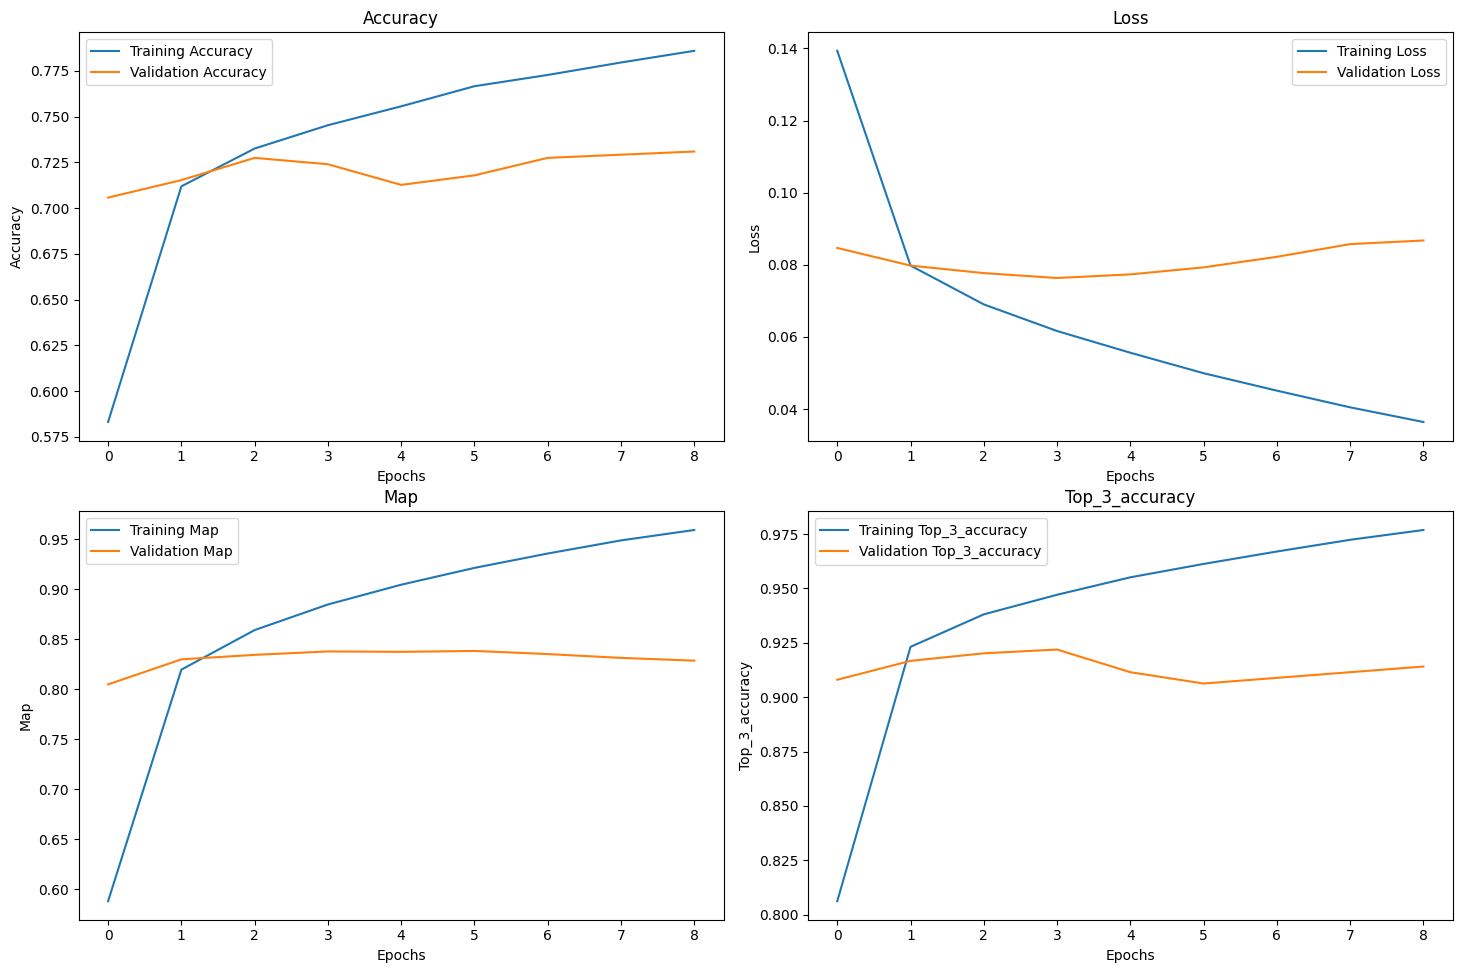

In [16]:
plot_history(history_base_mbnet)

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step - accuracy: 0.7052 - loss: 0.0812 - mAP: 0.6979 - top_3_accuracy: 0.9105
MobileNet Test Accuracy: 0.7118, Top-3 Accuracy: 0.8380, Mean Average Precision: 0.9158 
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step


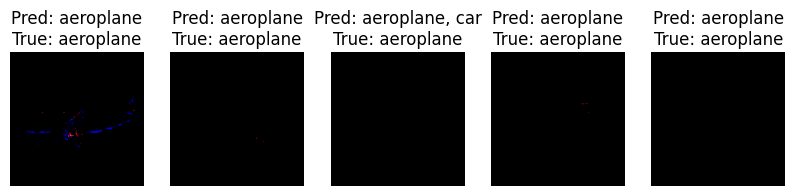

In [17]:
score_base_mbnet = evaluate_model(model_base_mbnet, mbnet_test_dataset, "MobileNet")

In [18]:
model_base_mbnet.save('model_base_mbnet.keras')

# Comparison

In [ ]:
scores = {
    'name': ['base_resnet', 'ft_resnet', 'base_vgg', 'ft_vgg', 'base_mbnet'],
    'acc' : [score_base_resnet['acc'], score_ft_resnet['acc'], score_base_vgg['acc'], score_ft_vgg['acc'], score_base_mbnet['acc']],
    'top_3_acc' : [score_base_resnet['top_3_acc'], score_ft_resnet['top_3_acc'], score_base_vgg['top_3_acc'], score_ft_vgg['top_3_acc'], score_base_mbnet['top_3_acc']],
    'map_metric' : [score_base_resnet['map_metric'], score_ft_resnet['map_metric'], score_base_vgg['map_metric'], score_ft_vgg['map_metric'], score_base_mbnet['map_metric']]
}

In [19]:
scores = {
    'name': ['base_resnet', 'ft_resnet', 'base_vgg', 'ft_vgg', 'base_mbnet'],
    'acc': [0.7352, 0.6901, 0.7057, 0.6997, 0.7118],
    'top_3_acc': [0.8337, 0.8024, 0.8255, 0.8203, 0.8380],
    'map_metric': [0.9123, 0.8819, 0.9010, 0.9045, 0.9158]
}

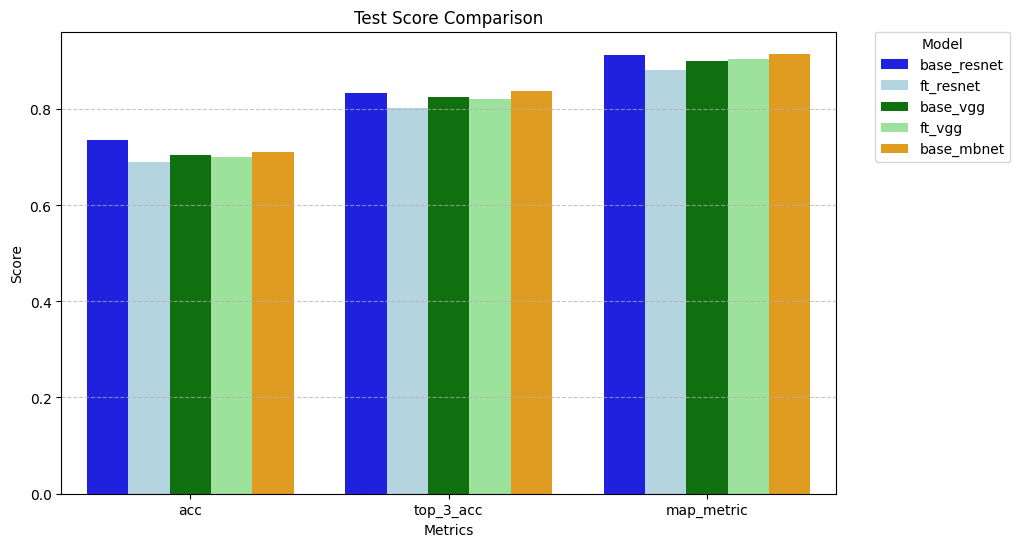

In [20]:
df = pd.DataFrame(scores)
df_melted = df.melt(id_vars="name", var_name="metric", value_name="score")

palette = {
    'base_resnet': 'blue',
    'ft_resnet': 'lightblue',
    'base_vgg': 'green',
    'ft_vgg': 'lightgreen',
    'base_mbnet': 'orange'
}

# Creazione del grafico
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="metric", y="score", hue="name", data=df_melted, palette=palette)

# Migliorare la leggibilità
plt.title("Test Score Comparison")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()